# computing birth death rates from fortranic trajectories
Tim Tyree<br>
7.7.2022

In [17]:
from lib.my_initialization import *
from lib import *

In [20]:
from scipy.stats import hmean
import seaborn as sns

In [21]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [22]:
def comp_death_rate(df_n,n_trgt=6):
    """measure n_trgt --> n_trgt-2 times
    
    Example Usage:
df_rate = comp_death_rates(df_n,n_trgt=6)
    """
    boo_trgt=df_n==n_trgt
    boo = ((df_n.shift(-1)==n_trgt-2)&(boo_trgt))
    if not boo.any():
        return None
    boo_event=df_n.shift(-1).diff()!=0 #for n-2 only (simple)
    event_times = boo_event[boo_event].index.values
    #boo = ((df_n.shift(-1)==n_trgt-2)&(boo_trgt))
    #count how many index values appear before each 
    dur_lst=[]
    death_rate_lst=[]
    for tf in boo[boo].index.values:
        booev = event_times<tf
        if booev.any():
            ti = np.max(event_times[booev])
            dur=tf-ti
            dur_lst.append(dur)
            death_rate_lst.append(1/dur)
    df_rate = pd.DataFrame(dict({
        'n_before':n_trgt,
        'death_rate':death_rate_lst,
        'dur':dur_lst,
    }))
    return df_rate

In [23]:
def comp_death_rates(df_n):
    """df_n is a series (time series) of numbers, indexed by time.
    comp_death_rates returns the transition rates in df_n as a pandas.DataFrame instance.
    
    Example Usage:
df_rates = comp_death_rates(df_n)
    """
    n_trgt_lst = sorted(df_n.drop_duplicates().values)
    df_rate_lst=[]
    for n_trgt in n_trgt_lst:
        df_rate = comp_death_rate(df_n,n_trgt)
        if df_rate is not None:
            df_rate_lst.append(df_rate)
    #if len(df_rate_lst)==0:
    #    return None
    df_rates = pd.concat(df_rate_lst)
    return df_rates

In [24]:
def reverse_time(df,t_col='t'):
    """reverse_time inverts the times recorded in df[t_col] inplace and returns df.
    df.index is also reset.
    applying reverse_time three times is the same as applying it once.
    
    Example Usage:
df_reversed = reverse_time(df.copy(),t_col='t')
    """
    ti = df[t_col].min()
    tf = df[t_col].max()
    df[t_col] = tf - df[t_col] + ti
    df.sort_values(by=t_col,inplace=True)
    df.reset_index(inplace=True,drop=True)
    return df

In [25]:
def eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,
    drop_odd=True,
    testing=True,
    printing=True,**kwargs):
    """
    Example Usage:
df_rates = eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,drop_odd=True,
    testing=True,printing=True)
    """
    assert os.path.exists(log_folder_parquet)

    max_trial_num=-9999
    for fn in os.listdir(log_folder_parquet):
        i=fn.find('=')
        if i>-1:
            trial_num = eval(fn[i+1:])
            if trial_num>max_trial_num:
                max_trial_num = trial_num

    #test there is no fewer files than the max_trial_num
    assert len(os.listdir(log_folder_parquet))>=max_trial_num

    if printing:
        print(f"searching {log_folder_parquet}...")
        print(f"found {max_trial_num} termination events")
        #print(f"max trial num found: {max_trial_num}")


    task_lst=[]
    for trial_num in list(range(max_trial_num+1)):
        task_lst.append((trial_num,str(log_folder_parquet)))
    if printing:
        print(f"added {len(task_lst)} tasks to task_lst!")

    def routine(task):
        trial_num,log_folder_parquet=task
        try:
            df=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
            df_n=df.groupby(by='t')['n'].mean()
            df_rates = comp_death_rates(df_n)
            df_rates['trial_num']=trial_num
            return df_rates
        except Exception as e:
            return None

    #fortranic spiral tip model test case
    if testing:
        task=task_lst[1]
        rv = routine(task)
        print(f"test routine returned an instance of type: {type(rv)}")
        print(f"{rv.shape=}\nrv.head(5):")
        print(rv.head(5))


    npartitions=np.min((npartitions,os.cpu_count()))
    if printing:
        print(f"computing death rates for {len(task_lst)} termination times over {npartitions} cpu cores (estimated run time <6 seconds)...")

    retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
    df_rates=pd.concat(retval)
    df_rates.reset_index(inplace=True)

    #identify any points with value for n_before that is odd
    descr = df_rates.groupby(by='n_before')['death_rate'].describe()
    boo_odd = 1==descr.index.values%2
    if boo_odd.any():
        if printing:
            print(f"warning: odd spiral tip counts were detected:")
            print(descr[boo_odd])

    #(optionally) drop all such odd points
    if drop_odd:
        booodd = (df_rates['n_before']%2==1)
        num_odd = np.sum(booodd)
        df_rates.drop(index=df_rates[booodd].index,inplace=True)
        if printing:
            print(f"dropped {num_odd} rows from df_rates for being odd.")
    if printing:
        print(f"rates were computed for {df_rates.shape[0]} pair-annihilation events. returning...")
    return df_rates

In [26]:
def boxplotscatter_plotter(ax,values_lst,xlabel_lst,
                           scale_scatter=0.1,
                           random_state=42,
                           ylabel='MSR (a.u.)',
                           fontsize=16,
                           marker_size = 5, 
                           marker_color = 'k', 
                           marker_alpha = .5,
                           rv_lst=None,
                           notch=True, flierprops=dict(markerfacecolor='black', marker='D'),
                           boxprops=dict(facecolor='gray'),
                           medianprops = dict(color='black'), 
                           widths = 0.5, showfliers=False,
                           **kwargs):
    """kwargs are passed directly to matplotlib.pyplot.boxplot
    
    Example Usage:
figsize=(3,4)
fig, ax = plt.subplots(figsize=figsize)   
    """
    #diamond = dict(markerfacecolor='black', marker='D')
    # mps = dict(color='black')
    np.random.seed(random_state)
    #randomly sample an x-offset for visualization purposes
    if rv_lst is None:
        rv_lst=[]
        xpos=1
        for values in values_lst:
            #sample x-offset values
            rv_1=np.random.rand(values.shape[0])
            rv=scale_scatter*(rv_1-.5)+xpos
            #record
            rv_lst.append(rv)
            #increment xpos
            xpos+=1

    #add scatter plot of data points
    for zorder,(rv,values) in enumerate(zip(rv_lst,values_lst)):
        ax.scatter(x = rv, y = values, s = marker_size, c= marker_color, alpha = marker_alpha, zorder=zorder+2)

    #add box and whisker plot
    # ax.boxplot(values, notch=True, flierprops=diamond,
    #             labels = xlabel_lst,
    #             patch_artist=True, boxprops=dict(facecolor='gray'),
    #             medianprops = mps, widths = 0.5, showfliers=False,  zorder = 1  )
    ax.boxplot(values_lst, notch=notch, flierprops=flierprops, labels = xlabel_lst,
                patch_artist=True, boxprops=boxprops, medianprops = medianprops, widths = widths, showfliers=showfliers,  zorder = 1  ,**kwargs)
    #format_plot
    format_plot(ax=ax,xlabel='',ylabel=ylabel,fontsize=fontsize)
    return ax


In [27]:
#TODO: move to lib.measures
def bootstrap_95CI_values_lst(values_lst,num_samples=1000):
    """
    Example Usage:
df_bar = bootstrap_95CI_values_lst(values_lst,num_samples=1000)
    """
    dic_lst=[]
    for values in values_lst:
        Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=num_samples)
        dic=dict(xbar=np.mean(values),
                 Delta_xbar=Delta_mean,
                 p_xbar=p,
                 num_obs_xbar=values.shape[0])
        dic_lst.append(dic)
    df_bar=pd.DataFrame(dic_lst)
    return df_bar

In [28]:
def recall_domain_area_parquet(log_folder_parquet,DS=0.025, round_area_to_n_digits=7):
    """DS is in units of centimeters betweeen units in the computational domain.
    recall_domain_area_parquet supposes anisotropy of a rectangular computational domain.
    
    Example Usage:
area = recall_domain_area_parquet(log_folder_parquet,DS=0.025)
    """
    df=load_parquet_by_trial_num(trial_num=0,folder_parquet=log_folder_parquet)
    width=np.around(df.x.max())
    height=np.around(df.y.max())
    area=DS**2*width*height
    return np.around(area,round_area_to_n_digits)

# measure annihilation rates from original tip position data

death_rate for n=6 --> n=4:    0.299402 Hz

Q: Does ^this agree with previously known values?


- 1/11.68 >>> 0.08561643835616438

_from wj's table for LR (A=25):_

No2, rate
2, 0.01820
3, 0.0377


- 1/0.0182 >>> 54.94505494505494
- 1/0.0377 >>> 26.525198938992045

conclusion: these rates are ~0.5X what i get from WJ's data for the LR model when diffCoeff=0.001.

THEREFORE: the annihilation rates in the LR model for Vidmar & Rappel (2019) DO in fact have diffCoeff=0.0005 for the LR model.

i.e. first pass suggests __WJ did not use tip_pos_001 to compute bdrates in Vidmar & Rappel (2019)__

In [31]:
#DONE: generate sweet boxand whisker plot
#DONE: wrapped the evaluation routine into a sweet two-linear call to my foo
#DONE: dev on two docstrings for pipeline io

In [51]:
data_folder = f'{nb_dir}/Data'
# lr
log_folder_parquet=f'{data_folder}/from_wjr/positions_lr/200x200/tippos_per_001_log/'

# #fk
log_folder_parquet=f'{data_folder}/from_wjr/positions_fk/200x200/tippos_per_c_001_log/'
printing=True
assert os.path.exists(log_folder_parquet)

In [52]:
df_rates = eval_routine_compute_pair_annihilation_rates(log_folder_parquet,
    npartitions=10,drop_odd=True,
    testing=True,printing=True)

searching /home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_log/...
found 80 termination events
added 81 tasks to task_lst!
test routine returned an instance of type: <class 'pandas.core.frame.DataFrame'>
rv.shape=(308, 4)
rv.head(5):
   n_before  death_rate   dur  trial_num
0       4.0    0.034483  29.0          1
1       4.0    0.052632  19.0          1
2       4.0    0.333333   3.0          1
3       4.0    0.037037  27.0          1
4       4.0    0.023810  42.0          1
computing death rates for 81 termination times over 10 cpu cores (estimated run time <6 seconds)...
run time for evaluating routine was 5.44 seconds, yielding 81 values returned
dropped 0 rows from df_rates for being odd.
rates were computed for 37149 pair-annihilation events. returning...


In [53]:
print(f"summary stats for each particle density:")
df_rates.groupby(by='n_before')['death_rate'].describe().T

summary stats for each particle density:


n_before,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0
count,1057.000000,3957.000000,7811.000000,9155.000000,7526.000000,4544.000000,2049.000000,751.000000,211.000000,57.000000,18.000000,8.000000,2.000000,1.0,2.000000
mean,0.093406,0.115018,0.123856,0.141812,0.159791,0.186106,0.220048,0.236456,0.286672,0.236827,0.297792,0.537649,0.175000,1.0,0.121795
std,0.161328,0.186663,0.184835,0.198538,0.211783,0.226203,0.252362,0.260976,0.275291,0.251160,0.256543,0.400823,0.106066,NaN,0.063458
min,0.002500,0.003058,0.002232,0.002392,0.004367,0.003484,0.004545,0.005319,0.013514,0.018519,0.050000,0.125000,0.100000,1.0,0.076923
25%,0.016129,0.021277,0.025641,0.030303,0.037037,0.043478,0.055556,0.062500,0.087121,0.055556,0.087500,0.185714,0.137500,1.0,0.099359
50%,0.033333,0.045455,0.052632,0.062500,0.076923,0.090909,0.125000,0.125000,0.200000,0.142857,0.200000,0.416667,0.175000,1.0,0.121795
75%,0.083333,0.111111,0.125000,0.166667,0.200000,0.250000,0.250000,0.333333,0.333333,0.333333,0.500000,1.000000,0.212500,1.0,0.144231
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.250000,1.0,0.166667


In [54]:
DS=0.025
area = recall_domain_area_parquet(log_folder_parquet,DS=DS)

# df_rates,
# area,
# ycol='death_rate'

ycol_lst=['death_rate','dur']

# use_final_n=True
use_final_n=False
num_samples=1000 #for bootstrap

#generate label data
xlabel_lst=[]
xval_lst=[]
for n,g in df_rates.groupby(by='n_before'):
    xlabel_lst.append(f"n: {int(n)}"+r"$\rightarrow$"+f"{int(n-2)}")
    xval_lst.append(int(n))

df_bar_lst=[]
for ycol in ycol_lst:
    #generate boxplot data
    values_lst=[]
    for n,g in df_rates.groupby(by='n_before'):
        x=g[ycol].values
        values_lst.append(x)
    #compute arithmetic mean
    df_bar = bootstrap_95CI_values_lst(values_lst,num_samples=num_samples)
    df_bar['n_before']=xval_lst

    #DONE: infer domain size of the folder
    #DONE: compute xy values

    df_bar[ycol]=df_bar['xbar']
    df_bar[f'Delta_{ycol}']=df_bar['Delta_xbar']
    if use_final_n:
        df_bar['q']=(df_bar['n_before']-2)/area
    else:
        df_bar['q']=df_bar['n_before']/area
    df_bar[f'w_{ycol}']=df_bar[ycol]/area
    df_bar[f'Delta_w_{ycol}']=df_bar[f'Delta_{ycol}']/area
    df_bar['area']=area
    #record
    df_bar_lst.append(df_bar)
# dfbar=pd.merge(df_bar_lst[0],df_bar_lst[1],
#                how='outer', on='n_before')
# dfbar=pd.merge(df_bar_lst[0],df_bar_lst[1],
# #                how='left', on='n_before')
# dfbar=pd.merge(df_bar_lst[0],df_bar_lst[1],
#                how='left', on='q')
# # #heretim
# # return dfbar
# dfbar.head()

In [55]:
#format results
dfbar=df_bar_lst[0].copy()
dfbar[ycol]=df_bar_lst[1][ycol]
dfbar[f'Delta_{ycol}']=df_bar_lst[1][f'Delta_{ycol}']
dfbar[f'w_{ycol}']=df_bar_lst[1][f'w_{ycol}']
dfbar[f'Delta_w_{ycol}']=df_bar_lst[1][f'Delta_w_{ycol}']

In [56]:
# #print columns before/after merging
# for d in df_bar_lst:
#     print(f"{list(d.columns)=}")

In [65]:
#visualize the apparent mean annihilation rate trace
x_values=dfbar['q'].values
# y_values=dfbar['w_death_rate'].values
# Delta_y_values=dfbar['Delta_w_death_rate'].values
y_values=dfbar['w_dur'].values
Delta_y_values=dfbar['Delta_dur'].values/y_values**2
#heretim
# qmax=0.4
qmax=0.7
#TODO: compute the powerlaw fit to ^this
boo=x_values<qmax
x=x_values[boo]
y=y_values[boo]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
print(f"{B=:.4f},{Delta_B=:.4f}, {m=:.4f},{Delta_m=:.4f} ({Rsq=:.4f})")
print(f"power law magnitude:\t{B:.4f} (+/- {Delta_B:.4f}) kHz/cm^(2nu-1)?")
print(f"power law exponent:\t{m:.4f} (+/- {Delta_m:.4f}) nu")
M, Delta_M = comp_power_scale(B, Delta_B, m, Delta_m)
#TODO: plot the powerlaw fit to ^this
M, Delta_M 

B=3.2521,Delta_B=0.7316, m=-0.8378,Delta_m=0.1685 (Rsq=0.9500)
power law magnitude:	3.2521 (+/- 0.7316) kHz/cm^(2nu-1)?
power law exponent:	-0.8378 (+/- 0.1685) nu


(0.372296996876313, 0.02416425046421128)

In [58]:
print_fit_power_law(x,y)
x.shape

y=M*(x)**m
m=-0.837832+-0.168491; B=3.252127+-0.731608
M= 0.372297+-0.024164 Hz*cm^{2(m-1)}
RMSE=0.1422 Hz/cm^2
R^2=0.9500


(7,)

In [63]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

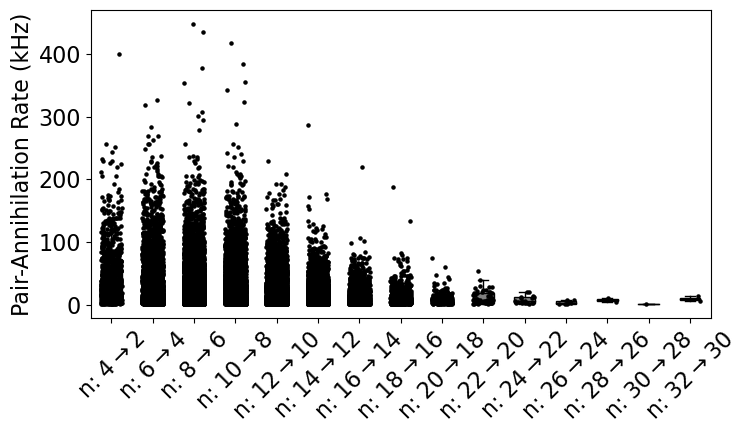

In [64]:
figsize=(8,4)
fig, ax = plt.subplots(figsize=figsize)   
boxplotscatter_plotter(ax,values_lst,xlabel_lst,random_state=42,
                           ylabel='Pair-Annihilation Rate (kHz)',fontsize=16,notch=False,scale_scatter=0.5,marker_alpha=1)#,**kwargs)
# ax.errorbar(bar_label_lst[0],bar_height_values[0],Delta_bar_height_values[0],alpha=0.9,color=color_lst[0])
# ax.set_title(title,fontsize=fontsize)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.sca(ax)
plt.xticks(rotation=45)
plt.show()

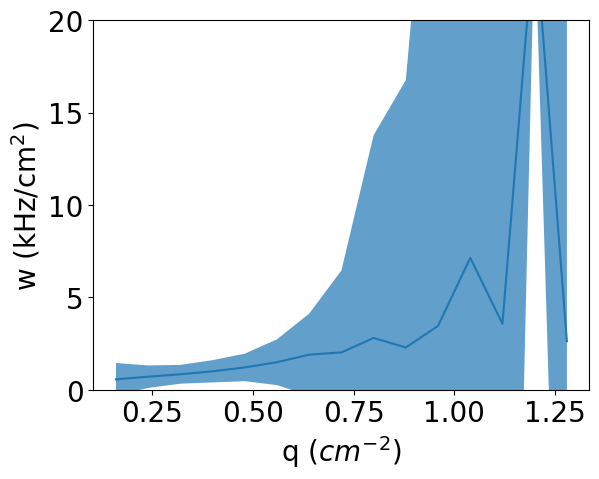

In [69]:
y_values=1/dfbar['w_dur'].values
Delta_y_values=dfbar['Delta_dur'].values*y_values**2

plt.plot(x_values,y_values)
plt.fill_between(x_values,y_values-Delta_y_values,y_values+Delta_y_values,alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim([0,20])
format_plot(ax=plt.gca(),xlabel=r'q ($cm^{-2}$)',ylabel=r'w (kHz/cm$^{2}$)')
plt.show()

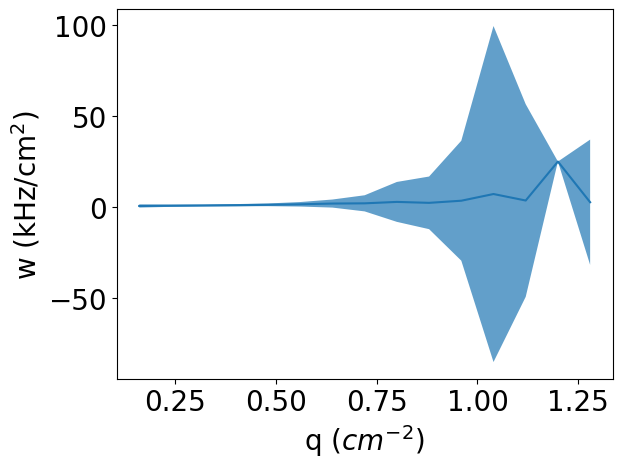

In [68]:
plt.plot(x_values,y_values)
plt.fill_between(x_values,y_values-Delta_y_values,y_values+Delta_y_values,alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
format_plot(ax=plt.gca(),xlabel=r'q ($cm^{-2}$)',ylabel=r'w (kHz/cm$^{2}$)')
plt.show()

In [70]:
print_fit_power_law(x,y)
x.shape

y=M*(x)**m
m=-0.837832+-0.168491; B=3.252127+-0.731608
M= 0.372297+-0.024164 Hz*cm^{2(m-1)}
RMSE=0.1422 Hz/cm^2
R^2=0.9500


(7,)

In [368]:
#visualize the apparent mean annihilation rate trace
x_values=dfbar['q'].values
y_values=1/dfbar['w_dur'].values
# Delta_y_values=(dfbar['Delta_w_dur'].values/dfbar['w_dur'].values)*y_values #fixing percent uncertainty
Delta_y_values=0.5*(dfbar['Delta_w_dur'].values/dfbar['w_dur'].values)*y_values #result from chain rule?
# y_values=dfbar['w_death_rate'].values
# Delta_y_values=dfbar['Delta_w_death_rate'].values

#heretim
# qmax=0.4
qmax=0.7
#TODO: compute the powerlaw fit to ^this
boo=x_values<qmax
x=x_values[boo]
y=y_values[boo]
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
# print(f"{B=:.4f},{Delta_B=:.4f}, {m=:.4f},{Delta_m=:.4f} ({Rsq=:.4f})")
# print(f"power law magnitude:\t{B:.4f} (+/- {Delta_B:.4f}) kHz/cm^(2nu-1)?")
# print(f"power law exponent:\t{m:.4f} (+/- {Delta_m:.4f}) nu")
# M, Delta_M = comp_power_scale(B, Delta_B, m, Delta_m)
#fit powerlaw 
print_fit_power_law(x,y)

y=M*(x)**m
m=1.198604+-0.077926; B=8.290067+-0.672853
M= 12.617913+-3.819377 Hz*cm^{2(m-1)}
RMSE=0.2168 Hz/cm^2
R^2=0.9945


Q: what was the previous powerlaw fit?

In [128]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)
print_dict(wjr)

fk_pbc lr_pbc
fk_pbc={'m': 1.8772341309722325, 'Delta_m': 0.02498750277237229, 'M': 5.572315674840435, 'Delta_M': 0.3053120355191732}
lr_pbc={'m': 1.6375562704001745, 'Delta_m': 0.017190912126700632, 'M': 16.73559858353835, 'Delta_M': 0.8465090320196467}


^That's way different... I bet ^this dissagreement is because the _parquet_ cache is currently filled with creation events instead of annihilation events!  If ^this is true, then plotting the average values should appear concave instead of convex

## etc

In [129]:
x_lst

[0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8, 0.88, 0.96]

In [130]:
ybar

xbar                7.500000e-01
Delta_xbar          3.410256e-01
p_xbar              2.350464e-34
num_obs_xbar        2.000000e+00
n_before            2.400000e+01
death_rate          7.500000e-01
Delta_death_rate    3.410256e-01
q                   9.600000e-01
w                   3.000000e-02
Delta_w             1.364102e-02
Name: 10, dtype: float64

In [131]:
xval_lst

[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

0 --> 0.05705037872115554
1 --> 0.0857002069577215
2 --> 0.12092806614072371
3 --> 0.16332773512476007
4 --> 0.2142747269650823
5 --> 0.2329430763019782
6 --> 0.30066225165562915
7 --> 0.3583815028901734
8 --> 0.35294117647058826
9 --> 0.2727272727272727
10 --> 0.6666666666666666


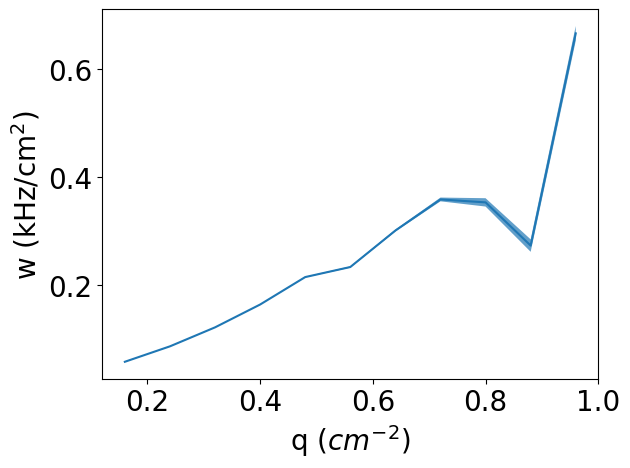

In [137]:
# TODO: print mean values with 95% ci
# HINT: 
# print(f"x --> ybar:")
x_lst=[]
y_lst=[]
for x,(xlabel,values) in enumerate(zip(xval_lst,values_lst)):
    bar=df_bar.loc[x]
    xhbar=hmean(values)
    #record
    x_lst.append(bar['q'])
    y_lst.append(xhbar)
    print(f"{x} --> {xhbar}")
    #print(f"{x} --> {dict(bar)}")
    
    
#TODO: visualize the apparent mean annihilation rate trace
x_values=np.array(x_lst)
y_values=np.array(y_lst)
# Delta_y_values=df_bar['Delta_w'].values

plt.plot(x_values,y_values)
plt.fill_between(x_values,y_values-Delta_y_values,y_values+Delta_y_values,alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
format_plot(ax=plt.gca(),xlabel=r'q ($cm^{-2}$)',ylabel=r'w (kHz/cm$^{2}$)')
plt.show()

In [133]:
#heretim
qmax=0.6
#TODO: compute the powerlaw fit to ^this
boo=x_values<qmax
x=x_values[boo]
y=y_values[boo]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
print(f"{B=:.4f},{Delta_B=:.4f}, {m=:.4f},{Delta_m=:.4f} ({Rsq=:.4f})")
print(f"power law magnitude:\t{B:.4f} (+/- {Delta_B:.4f}) kHz/cm^(2nu-1)?")
print(f"power law exponent:\t{m:.4f} (+/- {Delta_m:.4f}) nu")


#TODO: plot the powerlaw fit to ^this

B=0.5337,Delta_B=0.0521, m=1.1729,Delta_m=0.0878 (Rsq=0.9942)
power law magnitude:	0.5337 (+/- 0.0521) kHz/cm^(2nu-1)?
power law exponent:	1.1729 (+/- 0.0878) nu


In [134]:
print_fit_power_law(x,y)

y=M*(x)**m
m=1.172912+-0.087828; B=0.533681+-0.052126
M= 0.478769+-0.030795 Hz*cm^{2(m-1)}
RMSE=0.0068 Hz/cm^2
R^2=0.9942


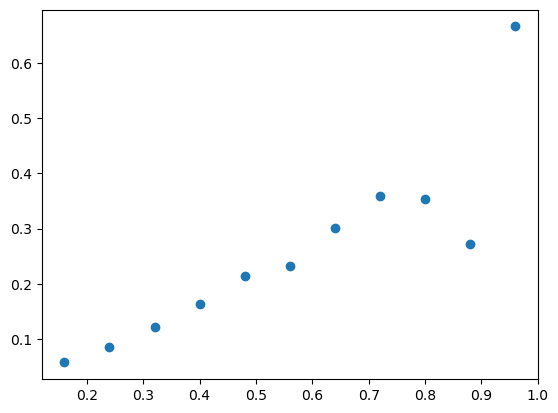

In [135]:
plt.scatter(x_lst,y_lst)

In [136]:
#heretim
#TODO(failing ^that/if exponents are significantly different): try using harmonic mean instead of arithmetic mean
#HINT:
hmean([1, 4])

1.6

In [81]:
#TODO: plot the powerlaw fit. is it like the annihilations or the creations?

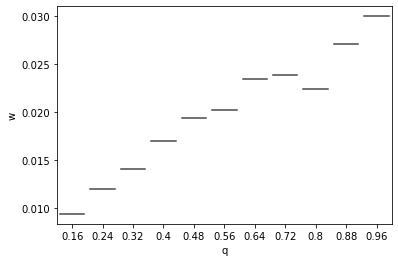

In [96]:
import seaborn as sns
ax = sns.violinplot(x="q", y="w", data=df_bar, inner=None)
ax = sns.swarmplot(x="q", y="w", data=df_bar,
                   color="white", edgecolor="gray")

In [100]:
#TODO: compute xy data in df_rates
df_rates['q'] = df_rates['n_before']/area
df_rates['w'] = df_rates['death_rate']/area
df_rates['winv'] = df_rates['dur']*area #expect: winv = 1/w

In [103]:
# #NOTE: swarmplot is good only for a small number of samples
# #DONE: swarmplot df_rates
# import seaborn as sns
# ax = sns.violinplot(x="q", y="w", data=df_rates, inner=None)
# ax = sns.swarmplot(x="q", y="w", data=df_rates,
#                    color="white", edgecolor="gray")

In [ ]:
#TODO: copy ^that plot to .odg

In [ ]:
#TODO: return q,w values before averaging
#TODO: scatter plot by considering annihilation rates from many log_parquet_folders
#TODO: plot the scatter plot of all observed q,w values from many log_parquet_folders
#TODO: bootstrap an xy trace for ^that
#TODO: compute the powerlaw fit to ^this
#TODO: plot the powerlaw fit to ^this

In [27]:
#TODO: generate plot of mean annihilation rates versus particle number. save to .odg
#TODO: generate plot of mean annihilation rated density versus particle density. save to .odg
#TODO: add violinplot in the background for each xlabel in xlabel_lst
#HINT: 
# for xlabel,values in zip(xlabel_lst,values_lst,dic_lst):
#     #TOOD: plot 95% ci with violin plot
#HINT:
# for xlabel,values in zip(xlabel_lst,values_lst):
#     Delta_mean,p=bootstrap_95CI_Delta_mean(values,num_samples=1000)

In [28]:
#TODO: compute ^this powerlaw fit

In [29]:
#TODO(later): functionally clean the parquet caches by using the following over a list of folders
# clean_parquet_by(folder_parquet)

# DONE: showed the existance of low rmse values for large ranges
- TODO: dev run 25 at smaller r,kappa values
- TODO: find the best r,kappa for either of the full models

In [12]:
#DONE: recall desired powerlaw fit
# Recall powerlaw fits to full models
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

# #select fenton-karma model
# dict_fit = wjr['fk_pbc']
# alinear= 1.553 #(16) cm^2/s
# D = 0.114 #(8) cm^2/s

#select luo-rudy model
dict_fit = wjr['lr_pbc']
alinear= 9.969 #(100) cm^2/s
D = 0.09 #(50) cm^2/s


print_dict(dict_fit)
m=dict_fit['m']
M=dict_fit['M']

fk_pbc lr_pbc
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467


In [15]:
def comp_rmse_powerlaw(df,q_values,M,m,dq=0.05):
    """
    Example Usage:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
df.sort_values(by='rmse',inplace=True)
df['rmse'].values
    """
    #compute q_values used by df
    q_min = df.q_min.drop_duplicates().values[0]
    q_max = df.q_max.drop_duplicates().values[0]
    q_values=np.arange(q_min,q_max,dq)
    #input: m,M, q_values used by df
    #output: w_values
    w_values=M*q_values**m

    #compute rmse for each row
    df['rmse']=np.nan
    for i,row in df.iterrows():
        m_ = row['m']
        M_ = row['M']
        w_values_linear=M_*q_values**m_
        df.loc[i,'rmse']= np.sqrt(np.mean((w_values_linear-w_values)**2))
    return df

In [16]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
df.sort_values(by='rmse',inplace=True)
df['rmse'].values

NameError: name 'q_values' is not defined

In [293]:
alinear

9.969

In [294]:
r=1.7
# col_lst=['varkappa','D','r','kappa','rmse']
col_lst=['varkappa','D','r','kappa','rmse', 'm', 'M']
boo = df['r']==r
print(f"{alinear=}, {D=}")
print(f"showing settings with {r=}, sorted by rmse")
df[boo][col_lst].head(20)

alinear=9.969, D=0.09
showing settings with r=1.7, sorted by rmse


,varkappa,D,r,kappa,rmse,m,M
1354,1.553,0.114,1.7,10,3.492767,2.735264,41.831489
2275,9.969,0.090,1.7,10,3.541269,2.657610,40.864289
70,1.553,0.090,1.7,10,3.580897,2.742509,42.367299
1312,9.969,0.114,1.7,10,3.858362,2.672519,42.556704
2023,9.969,0.114,1.7,15,7.909668,2.663472,60.498531
2111,1.553,0.090,1.7,15,8.055386,2.691712,61.844425
2642,1.553,0.114,1.7,15,8.169136,2.712927,62.888741
1621,9.969,0.090,1.7,15,8.239523,2.722075,63.439471
3865,9.969,0.090,1.7,20,12.521384,2.666927,80.888226
176,1.553,0.114,1.7,20,12.913066,2.755565,85.676180


In [296]:
# r=1.7
# col_lst=['varkappa','D','r','kappa','rmse']
col_lst=['varkappa','D','r','kappa','rmse', 'm', 'M']
boo = df['r']==r
print(f"{alinear=}, {D=}")
print(f"showing settings with any r, sorted by rmse")
df[col_lst].head(20)

alinear=9.969, D=0.09
showing settings with any r, sorted by rmse


,varkappa,D,r,kappa,rmse,m,M
1770,9.969,0.114,0.1,365,0.195730,1.785239,17.872971
183,9.969,0.090,0.1,360,0.226850,1.780952,17.570390
3821,9.969,0.090,0.1,375,0.233233,1.817953,18.248351
3071,9.969,0.090,0.1,380,0.241542,1.821264,18.430598
3946,9.969,0.114,0.1,350,0.246114,1.816769,18.009566
3649,9.969,0.090,0.1,350,0.246122,1.787446,17.562223
1553,9.969,0.114,0.1,370,0.247127,1.814590,18.514979
4184,9.969,0.114,0.1,355,0.250966,1.799923,17.707876
3029,9.969,0.114,0.1,360,0.259558,1.838878,18.410090
67,9.969,0.090,0.1,390,0.260380,1.815805,18.609376


In [266]:
# df.plot.scatter(x='r',y='rmse')

In [241]:
#GOAL: compute r,kappa for a given best powerlaw fit
#heretim

In [232]:
# plt.plot(q_values,w_values)
m,M

(1.8772341309722325, 5.572315674840435)

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
3561,1.449377,0.042235,1.191753,0.053949,0.997794,0.010066,1.311481,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
1454,1.529165,0.020763,3.840482,0.149269,0.999520,0.011808,0.333821,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
2814,1.497712,0.050668,1.493514,0.092115,0.997030,0.014368,1.202696,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
3196,1.666051,0.037442,1.889397,0.105285,0.998687,0.014483,1.109855,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
3345,1.481496,0.026378,3.558011,0.174670,0.999175,0.015006,0.403763,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,3.839635,0.732940,1647.449093,11869.236996,0.913366,77.073741,275.459698,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
907,3.707462,0.720661,1641.561828,11833.187548,0.910452,77.603291,289.251348,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
3252,3.736928,0.695304,1735.088473,11531.827373,0.917333,79.762805,299.543535,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
1292,3.841446,0.777649,1577.930472,13331.206463,0.903607,81.792549,270.053129,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001


In [237]:
query = df['varkappa']==alinear
query = df['D']==D
df[query]

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
3,2.980217,0.194279,753.017363,630.658987,0.989059,13.609009,148.121012,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4,2.819897,0.135194,896.395715,513.445378,0.994052,12.625235,186.928423,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
5,2.464436,0.035075,41.298856,3.905511,0.999473,0.146161,4.063530,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
10,2.286157,0.074568,6.618411,0.951539,0.997238,0.071230,0.103591,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
11,3.221779,0.288449,742.418751,990.365211,0.979561,16.625390,134.511982,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,1.836041,0.078894,18.812289,4.185050,0.995217,0.266536,0.346706,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4228,2.432355,0.076530,8.026737,1.368787,0.997430,0.101718,0.277386,fk_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4229,5.156345,0.486294,478.735355,1066.725600,0.977371,8.584003,34.974299,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4230,2.698620,0.144234,1931.636707,1419.244524,0.992619,34.114135,437.730621,lr_pbc,0.24,0.75,...,0,5,2,1,0,0,0,0,0.00001,0.00001


In [230]:
#TODO: fork old method of minimizing the mse using Nelder-Mead

In [ ]:
#HINT:

In [216]:

#define constant parameters
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10
testing=False #True yields an extra runtimme of ~2 minutes

In [ ]:
input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_19_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_20_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_21_all_powerlaw_fits.csv"#too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_22_all_powerlaw_fits.csv" #too low varkappa
# input_fn=f"{nb_dir}/data/osg_output/run_23_all_powerlaw_fits.csv" #too low varkappa
input_fn=f"{nb_dir}/data/osg_output/run_24_all_powerlaw_fits.csv" #run 24 does not exist...
df=pd.read_csv(input_fn)

print(f"parameter range:")
print(df.describe()[['varkappa','D','L','r','kappa']].T[['min','max']].T)
print(f"\nalinear values considered: {sorted(df['varkappa'].drop_duplicates().values)} cm^2/s")

# print(f"\n\n(more details:)")
# print(df.describe().T[['min','max']])


In [ ]:
# #neighbor-only forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
# neighbor=1
# vector-summed forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
neighbor=0

#TODO: aggregate powerlaw fits with neighbor-only or vector-summed fits 
#TODO: aggregate powerlaw fits with D>=1.2


df=pd.read_csv(input_fn)
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#
input_cols=['r','kappa','varkappa','D']#
# output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime paradoxically...
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values

In [ ]:
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')
print(f"estimated runtime is ~{20+120*int(testing)} seconds...")

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
if testing:
    yhat = interp(X)
    print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

    rmse=np.sqrt(np.mean((yhat-y)**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")

In [217]:
model_name='lr_pbc'
c='C1'
# model_name='fk_pbc'
# c='C0'

#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

In [ ]:
#DONE: plotted how bad the fits are if LR gets alinear~3 instead of alinear~10
# a=a_hat_LR_long
# # a=a_hat_LR
# D=D_hat_LR

#from fit to wj's LR positions (200x200, diffcoeff: 0.001)
a=9.969
D=0.09

#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
# x0 = (0.1, 500)
# x0 = (.2, 100)
x0 = (.3, 100)
res = minimize(comp_rmse_via_interp, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
# rmse=comp_rmse_via_interp(res.x, *args)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")